# Exercise 14.X02 - Physics-Informed Neural Networks for inverse problems

In exercise 14.X02 we re-implement the demo of the Inverse problem for the Lorenz system with exogenous input ( [DeepXDE documentation](https://deepxde.readthedocs.io/en/latest/demos/pinn_inverse/lorenz.inverse.forced.html) ). This exercise was for us mainly an occasion to learn how to solve inverse problems with PINNs and familiarize with the library DeepXDE, for this reason, just some minor details such as the shape of the exogenous input are modified.

In this example, the Lorenz system subjected to an external force $f(t) = 10 \cdot sin(2\pi t) \cdot cos(2\pi t)$. The purpose of the exercise is to "discover" the Lorenz parameters $\sigma$, $\rho$ and $\beta$ from training data, thanks to the possibility of defining them as "trainable parameters" in the DeepXDE library.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy 
from scipy.integrate import odeint
import re

# Import deepxde and select desired backend.
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()
import deepxde as dde

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


Generate the data to train the neural network.

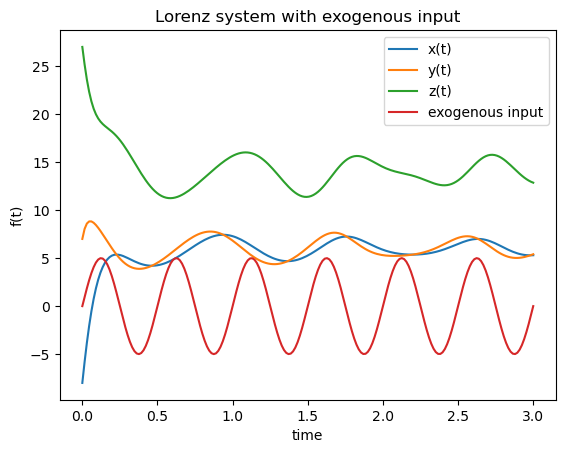

In [2]:
# plot function
def plot1( lorenz , ex_input ):
    
    plt.plot( time , lorenz[ : , 0 ] , label = "x(t)" )
    plt.plot( time , lorenz[ : , 1 ] , label = "y(t)" ) 
    plt.plot( time , lorenz[ : , 2 ] , label = "z(t)" )
    plt.plot( time , ex_input , label = "exogenous input" )
    
    plt.xlabel("time")
    plt.ylabel("f(t)")
    plt.title("Lorenz system with exogenous input")
    plt.legend()
    plt.show()

# Define problem parameters.
sigma_true = 10
rho_true = 15
beta_true = 8 / 3

# Define time domain.
T = 3
time = np.linspace( 0 , T , 200 )

# Define exogenous input.
ex_input = 10 * np.sin( 2 * np.pi * time ) * np.cos( 2 * np.pi * time ) 

# Define initial conditions.
x0 = [ -8 , 7 , 27 ]

# Define interpolating function for using exogenous variable without fixed time stamps.
def int_func(t):
    spline = scipy.interpolate.Rbf( time , ex_input , function = "thin_plate" , smooth = 0, episilon = 0 )
    return spline( t )

# Modified Lorenz system (with exogenous input)
def RHSLorez( sys , t ):
    x, y, z = sys    
    dsysdt = [ sigma_true * ( y - x) , x * ( rho_true - z ) - y , x * y - beta_true * z + int_func(t) ]
    return dsysdt

# solve ODE
lorenz = odeint( RHSLorez , x0 , time )
plot1( lorenz , ex_input )

time = time.reshape(-1, 1)

Defie trainable variables $\sigma$ , $\rho$ and $\beta$, which are now initialized to $1.0$.

In [3]:
sigma = dde.Variable(1.0)
rho = dde.Variable(1.0)
beta = dde.Variable(1.0)

Create the Lorenz system.

In [4]:
def Lorenz_system( t , sys , f ):
    
    """
    INPUT:
    t ( vec ): time coordinat
    sys ( array ): output of the network.
    f ( func ): exogenous function.
    
    OUTPU:
    lorenz system.
    
    """
    
    x , y , z = sys[ : , 0:1 ], sys[ : , 1:2 ], sys[ : , 2: ]
    dx_t = dde.grad.jacobian( sys , t , i = 0 )
    dy_t = dde.grad.jacobian( sys , t , i = 1 )
    dz_t = dde.grad.jacobian( sys , t , i = 2 )
    
    return [ dx_t - sigma * ( y - x ) , dy_t - x * ( rho - z ) + y , dz_t - x * y + beta * z - f ]

The ```TimeDomain``` is used to initialize a ```geom``` object, needed to define uinitial conditions with ```dde```. Similarly, the ```boundary``` function should return ```True``` for points inside the subdomain and ```False``` for the points outside and it is also used to specify the initial conditions icx , icy and icz. 

In [5]:
# Initialize the TimeDomain object.
geom = dde.geometry.TimeDomain( 0 , T )

# Define initial conditions.
def boundary( _ , on_initial ):
    return on_initial
icx = dde.icbc.IC( geom , lambda X: x0[0] , boundary, component = 0 )
icy = dde.icbc.IC( geom , lambda X: x0[1] , boundary, component = 1 )
icz = dde.icbc.IC( geom , lambda X: x0[2] , boundary, component = 2 )

Training data are organized thanks to the numerical integration performed above.

In [6]:
# Assign training data.
observe_x = dde.icbc.PointSetBC( time , lorenz[ : , 0:1 ] , component = 0 )
observe_y = dde.icbc.PointSetBC( time , lorenz[ : , 1:2 ] , component = 1 )
observe_z = dde.icbc.PointSetBC( time , lorenz[ : , 2:3 ] , component = 2 )

The data object defined below contains all the information about the Lorenz system and the customed domain we used in the exercise:

In [7]:
# define data object
data = dde.data.PDE(
    geom ,
    Lorenz_system , # analytical description of Lorenz system.
    [ icx , icy , icz , observe_x , observe_y , observe_z ], # initial conditions + dataset.
    num_domain = 400 , # number of points in the time domain.
    num_boundary = 2, # number of points on the boundary.
    anchors = time , # additional points (beyond num_domain and num_boundary) used for training.
    auxiliary_var_function = int_func , # interpolation function.
)

The neural network is defined as follow:
- input has dimension 1.
- there are 3 hidden layers with 40 units weach and tanh as activation function (other deeper configuration with less units per layer were tried, however with poorer results).
- output has dimension 3 and a linear activation function.

Additionally, callbacks are define to store results and the model is trained for 10000 epochs.

In [8]:
fnamevar = "variables.dat"

In [9]:
net = dde.nn.FNN( [1] + [40] * 3 + [3], "tanh", "Glorot uniform" )
model = dde.Model( data , net )
model.compile( "adam" , lr = 0.001 , external_trainable_variables = [ sigma , rho , beta ])

variable = dde.callbacks.VariableValue( [ sigma , rho , beta ], period = 100, filename = fnamevar )
model.train( iterations = 90000, callbacks = [ variable ] )

Compiling model...
'compile' took 0.000228 s



Training model...



Step      Train loss                                                                                    Test loss                                                                                     Test metric


0         [1.42e-01, 2.31e-01, 1.25e+01, 6.40e+01, 4.90e+01, 7.29e+02, 3.34e+01, 4.07e+01, 2.14e+02]    [1.42e-01, 2.31e-01, 1.25e+01, 6.40e+01, 4.90e+01, 7.29e+02, 3.34e+01, 4.07e+01, 2.14e+02]    []  


1000      [4.21e+00, 3.39e+00, 1.31e+01, 3.52e+01, 7.98e-03, 1.31e+00, 3.53e+01, 6.60e+00, 1.19e+01]    [4.21e+00, 3.39e+00, 1.31e+01, 3.52e+01, 7.98e-03, 1.31e+00, 3.53e+01, 6.60e+00, 1.19e+01]    []  


2000      [8.28e+00, 2.16e+00, 9.52e+00, 1.92e+01, 2.38e-01, 1.40e+00, 3.56e+01, 1.28e+01, 5.93e+00]    [8.28e+00, 2.16e+00, 9.52e+00, 1.92e+01, 2.38e-01, 1.40e+00, 3.56e+01, 1.28e+01, 5.93e+00]    []  


3000      [9.07e+00, 2.08e+00, 5.29e+00, 1.48e+01, 2.69e-01, 1.06e+00, 3.54e+01, 1.54e+01, 4.58e+00]    [9.07e+00, 2.08e+00, 5.29e+00, 1.48e+01, 2.69e-01, 1.06e+00, 3.54e+01, 1.54e+01, 4.58e+00]    []  


4000      [8.61e+00, 2.18e+00, 2.82e+00, 1.14e+01, 2.65e-01, 8.51e-01, 3.55e+01, 1.81e+01, 2.99e+00]    [8.61e+00, 2.18e+00, 2.82e+00, 1.14e+01, 2.65e-01, 8.51e-01, 3.55e+01, 1.81e+01, 2.99e+00]    []  


5000      [8.53e+00, 2.28e+00, 1.24e+00, 9.33e+00, 2.53e-01, 8.62e-01, 3.46e+01, 1.89e+01, 2.41e+00]    [8.53e+00, 2.28e+00, 1.24e+00, 9.33e+00, 2.53e-01, 8.62e-01, 3.46e+01, 1.89e+01, 2.41e+00]    []  


6000      [8.15e+00, 2.57e+00, 5.08e-01, 7.83e+00, 2.37e-01, 8.08e-01, 3.43e+01, 1.92e+01, 1.84e+00]    [8.15e+00, 2.57e+00, 5.08e-01, 7.83e+00, 2.37e-01, 8.08e-01, 3.43e+01, 1.92e+01, 1.84e+00]    []  


7000      [7.69e+00, 3.01e+00, 2.55e-01, 6.51e+00, 2.29e-01, 7.36e-01, 3.35e+01, 1.91e+01, 1.76e+00]    [7.69e+00, 3.01e+00, 2.55e-01, 6.51e+00, 2.29e-01, 7.36e-01, 3.35e+01, 1.91e+01, 1.76e+00]    []  


8000      [6.12e+00, 4.65e+00, 1.94e-01, 5.13e+00, 2.28e-01, 5.36e-01, 2.95e+01, 1.97e+01, 3.28e+00]    [6.12e+00, 4.65e+00, 1.94e-01, 5.13e+00, 2.28e-01, 5.36e-01, 2.95e+01, 1.97e+01, 3.28e+00]    []  


9000      [1.00e+00, 2.05e+00, 5.07e-01, 1.71e+00, 3.50e-01, 7.70e-02, 5.17e+00, 5.82e+00, 1.26e+01]    [1.00e+00, 2.05e+00, 5.07e-01, 1.71e+00, 3.50e-01, 7.70e-02, 5.17e+00, 5.82e+00, 1.26e+01]    []  


10000     [4.11e-01, 1.06e+00, 4.16e-01, 7.39e-01, 1.32e-01, 2.54e-04, 1.96e+00, 2.34e+00, 8.46e+00]    [4.11e-01, 1.06e+00, 4.16e-01, 7.39e-01, 1.32e-01, 2.54e-04, 1.96e+00, 2.34e+00, 8.46e+00]    []  


11000     [2.60e-01, 6.46e-01, 3.36e-01, 4.01e-01, 4.02e-02, 1.43e-02, 9.88e-01, 1.16e+00, 5.05e+00]    [2.60e-01, 6.46e-01, 3.36e-01, 4.01e-01, 4.02e-02, 1.43e-02, 9.88e-01, 1.16e+00, 5.05e+00]    []  


12000     [1.64e-01, 3.88e-01, 2.36e-01, 1.98e-01, 8.42e-03, 2.02e-02, 6.06e-01, 6.76e-01, 2.72e+00]    [1.64e-01, 3.88e-01, 2.36e-01, 1.98e-01, 8.42e-03, 2.02e-02, 6.06e-01, 6.76e-01, 2.72e+00]    []  


13000     [1.09e-01, 2.55e-01, 1.47e-01, 9.67e-02, 3.61e-03, 2.06e-02, 3.89e-01, 4.04e-01, 1.26e+00]    [1.09e-01, 2.55e-01, 1.47e-01, 9.67e-02, 3.61e-03, 2.06e-02, 3.89e-01, 4.04e-01, 1.26e+00]    []  


14000     [6.58e-02, 1.44e-01, 9.40e-02, 5.50e-02, 1.08e-03, 1.32e-02, 2.31e-01, 2.24e-01, 5.08e-01]    [6.58e-02, 1.44e-01, 9.40e-02, 5.50e-02, 1.08e-03, 1.32e-02, 2.31e-01, 2.24e-01, 5.08e-01]    []  


15000     [4.69e-02, 8.27e-02, 5.23e-02, 2.67e-02, 3.10e-04, 8.53e-03, 1.21e-01, 1.11e-01, 1.88e-01]    [4.69e-02, 8.27e-02, 5.23e-02, 2.67e-02, 3.10e-04, 8.53e-03, 1.21e-01, 1.11e-01, 1.88e-01]    []  


16000     [3.23e-02, 4.51e-02, 2.80e-02, 1.06e-02, 6.98e-05, 4.10e-03, 6.06e-02, 5.43e-02, 7.79e-02]    [3.23e-02, 4.51e-02, 2.80e-02, 1.06e-02, 6.98e-05, 4.10e-03, 6.06e-02, 5.43e-02, 7.79e-02]    []  


17000     [2.67e-02, 2.47e-02, 1.72e-02, 3.82e-03, 4.24e-05, 1.63e-03, 2.72e-02, 2.42e-02, 3.40e-02]    [2.67e-02, 2.47e-02, 1.72e-02, 3.82e-03, 4.24e-05, 1.63e-03, 2.72e-02, 2.42e-02, 3.40e-02]    []  


18000     [1.77e-02, 1.64e-02, 1.35e-02, 1.23e-03, 9.14e-07, 1.66e-04, 1.13e-02, 1.01e-02, 1.45e-02]    [1.77e-02, 1.64e-02, 1.35e-02, 1.23e-03, 9.14e-07, 1.66e-04, 1.13e-02, 1.01e-02, 1.45e-02]    []  


19000     [1.74e-02, 1.28e-02, 1.18e-02, 2.96e-04, 3.24e-06, 8.82e-06, 4.44e-03, 3.93e-03, 5.79e-03]    [1.74e-02, 1.28e-02, 1.18e-02, 2.96e-04, 3.24e-06, 8.82e-06, 4.44e-03, 3.93e-03, 5.79e-03]    []  


20000     [1.26e-02, 9.51e-03, 7.97e-03, 8.92e-05, 2.85e-05, 2.36e-05, 1.77e-03, 1.62e-03, 2.54e-03]    [1.26e-02, 9.51e-03, 7.97e-03, 8.92e-05, 2.85e-05, 2.36e-05, 1.77e-03, 1.62e-03, 2.54e-03]    []  


21000     [1.09e-02, 8.05e-03, 6.83e-03, 5.06e-05, 2.19e-05, 8.81e-07, 8.53e-04, 8.27e-04, 1.31e-03]    [1.09e-02, 8.05e-03, 6.83e-03, 5.06e-05, 2.19e-05, 8.81e-07, 8.53e-04, 8.27e-04, 1.31e-03]    []  


22000     [2.93e-02, 1.50e-02, 2.53e-02, 5.38e-07, 1.04e-04, 1.04e-04, 5.41e-04, 5.50e-04, 1.08e-03]    [2.93e-02, 1.50e-02, 2.53e-02, 5.38e-07, 1.04e-04, 1.04e-04, 5.41e-04, 5.50e-04, 1.08e-03]    []  


23000     [8.74e-03, 6.48e-03, 5.39e-03, 1.05e-05, 2.22e-05, 4.95e-06, 3.65e-04, 3.53e-04, 5.83e-04]    [8.74e-03, 6.48e-03, 5.39e-03, 1.05e-05, 2.22e-05, 4.95e-06, 3.65e-04, 3.53e-04, 5.83e-04]    []  


24000     [8.48e-03, 5.99e-03, 5.60e-03, 2.75e-05, 2.31e-05, 2.69e-06, 2.68e-04, 2.68e-04, 4.42e-04]    [8.48e-03, 5.99e-03, 5.60e-03, 2.75e-05, 2.31e-05, 2.69e-06, 2.68e-04, 2.68e-04, 4.42e-04]    []  


25000     [8.08e-03, 8.43e-03, 6.90e-03, 3.44e-05, 1.21e-05, 2.60e-05, 2.08e-04, 2.42e-04, 4.26e-04]    [8.08e-03, 8.43e-03, 6.90e-03, 3.44e-05, 1.21e-05, 2.60e-05, 2.08e-04, 2.42e-04, 4.26e-04]    []  


26000     [7.12e-03, 5.01e-03, 4.42e-03, 6.54e-06, 1.98e-06, 2.07e-05, 1.97e-04, 1.82e-04, 2.86e-04]    [7.12e-03, 5.01e-03, 4.42e-03, 6.54e-06, 1.98e-06, 2.07e-05, 1.97e-04, 1.82e-04, 2.86e-04]    []  


27000     [5.96e-03, 4.48e-03, 3.82e-03, 7.28e-06, 2.05e-09, 1.22e-05, 1.59e-04, 1.48e-04, 2.36e-04]    [5.96e-03, 4.48e-03, 3.82e-03, 7.28e-06, 2.05e-09, 1.22e-05, 1.59e-04, 1.48e-04, 2.36e-04]    []  


28000     [5.65e-03, 4.19e-03, 4.02e-03, 1.47e-06, 3.88e-06, 3.27e-11, 1.33e-04, 1.19e-04, 2.01e-04]    [5.65e-03, 4.19e-03, 4.02e-03, 1.47e-06, 3.88e-06, 3.27e-11, 1.33e-04, 1.19e-04, 2.01e-04]    []  


29000     [5.58e-03, 3.87e-03, 3.87e-03, 6.81e-06, 5.23e-07, 1.73e-06, 1.06e-04, 1.26e-04, 1.68e-04]    [5.58e-03, 3.87e-03, 3.87e-03, 6.81e-06, 5.23e-07, 1.73e-06, 1.06e-04, 1.26e-04, 1.68e-04]    []  


30000     [4.58e-03, 3.90e-03, 2.97e-03, 9.54e-06, 2.85e-07, 1.42e-05, 9.38e-05, 9.81e-05, 1.54e-04]    [4.58e-03, 3.90e-03, 2.97e-03, 9.54e-06, 2.85e-07, 1.42e-05, 9.38e-05, 9.81e-05, 1.54e-04]    []  


31000     [4.51e-03, 3.85e-03, 3.09e-03, 1.46e-09, 5.03e-07, 3.24e-06, 8.71e-05, 8.19e-05, 1.30e-04]    [4.51e-03, 3.85e-03, 3.09e-03, 1.46e-09, 5.03e-07, 3.24e-06, 8.71e-05, 8.19e-05, 1.30e-04]    []  


32000     [1.35e-02, 7.84e-03, 7.86e-03, 6.13e-07, 1.10e-04, 1.21e-04, 7.34e-05, 8.90e-05, 2.74e-04]    [1.35e-02, 7.84e-03, 7.86e-03, 6.13e-07, 1.10e-04, 1.21e-04, 7.34e-05, 8.90e-05, 2.74e-04]    []  


33000     [5.83e-03, 4.07e-03, 5.80e-03, 1.81e-05, 5.25e-06, 4.69e-06, 5.79e-05, 1.04e-04, 1.28e-04]    [5.83e-03, 4.07e-03, 5.80e-03, 1.81e-05, 5.25e-06, 4.69e-06, 5.79e-05, 1.04e-04, 1.28e-04]    []  


34000     [3.68e-03, 3.12e-03, 2.43e-03, 8.15e-06, 1.21e-09, 1.10e-05, 5.75e-05, 6.59e-05, 9.62e-05]    [3.68e-03, 3.12e-03, 2.43e-03, 8.15e-06, 1.21e-09, 1.10e-05, 5.75e-05, 6.59e-05, 9.62e-05]    []  


35000     [4.43e-03, 3.06e-03, 2.72e-03, 2.63e-06, 1.14e-05, 2.21e-05, 6.46e-05, 5.58e-05, 8.19e-05]    [4.43e-03, 3.06e-03, 2.72e-03, 2.63e-06, 1.14e-05, 2.21e-05, 6.46e-05, 5.58e-05, 8.19e-05]    []  


36000     [3.35e-03, 4.46e-03, 2.65e-03, 2.22e-05, 2.76e-06, 7.11e-05, 4.90e-05, 5.33e-05, 1.14e-04]    [3.35e-03, 4.46e-03, 2.65e-03, 2.22e-05, 2.76e-06, 7.11e-05, 4.90e-05, 5.33e-05, 1.14e-04]    []  


37000     [2.86e-03, 2.50e-03, 1.87e-03, 2.75e-06, 1.94e-06, 2.71e-07, 4.25e-05, 4.28e-05, 6.48e-05]    [2.86e-03, 2.50e-03, 1.87e-03, 2.75e-06, 1.94e-06, 2.71e-07, 4.25e-05, 4.28e-05, 6.48e-05]    []  


38000     [5.58e-03, 6.82e-03, 4.67e-03, 7.69e-06, 3.41e-05, 8.93e-05, 4.34e-05, 4.04e-05, 1.92e-04]    [5.58e-03, 6.82e-03, 4.67e-03, 7.69e-06, 3.41e-05, 8.93e-05, 4.34e-05, 4.04e-05, 1.92e-04]    []  


39000     [2.62e-03, 2.33e-03, 1.77e-03, 1.38e-06, 1.41e-06, 1.27e-07, 3.73e-05, 3.52e-05, 5.56e-05]    [2.62e-03, 2.33e-03, 1.77e-03, 1.38e-06, 1.41e-06, 1.27e-07, 3.73e-05, 3.52e-05, 5.56e-05]    []  


40000     [7.02e-03, 1.12e-02, 7.27e-03, 1.83e-05, 3.77e-05, 1.44e-04, 4.20e-05, 4.41e-05, 3.12e-04]    [7.02e-03, 1.12e-02, 7.27e-03, 1.83e-05, 3.77e-05, 1.44e-04, 4.20e-05, 4.41e-05, 3.12e-04]    []  


41000     [2.89e-03, 2.99e-03, 1.92e-03, 1.32e-05, 4.00e-06, 3.87e-05, 3.34e-05, 3.98e-05, 7.17e-05]    [2.89e-03, 2.99e-03, 1.92e-03, 1.32e-05, 4.00e-06, 3.87e-05, 3.34e-05, 3.98e-05, 7.17e-05]    []  


42000     [1.83e-02, 4.69e-03, 1.70e-02, 2.61e-05, 3.21e-05, 3.55e-05, 3.53e-05, 2.38e-04, 1.57e-04]    [1.83e-02, 4.69e-03, 1.70e-02, 2.61e-05, 3.21e-05, 3.55e-05, 3.53e-05, 2.38e-04, 1.57e-04]    []  


43000     [2.27e-03, 2.08e-03, 1.62e-03, 4.22e-07, 1.04e-08, 1.40e-06, 3.10e-05, 2.82e-05, 4.37e-05]    [2.27e-03, 2.08e-03, 1.62e-03, 4.22e-07, 1.04e-08, 1.40e-06, 3.10e-05, 2.82e-05, 4.37e-05]    []  


44000     [7.26e-03, 3.10e-03, 4.32e-03, 2.63e-08, 1.26e-04, 7.89e-05, 3.07e-05, 2.44e-05, 4.50e-05]    [7.26e-03, 3.10e-03, 4.32e-03, 2.63e-08, 1.26e-04, 7.89e-05, 3.07e-05, 2.44e-05, 4.50e-05]    []  


45000     [2.04e-03, 1.93e-03, 1.47e-03, 9.26e-07, 4.66e-07, 5.03e-07, 2.58e-05, 2.45e-05, 3.78e-05]    [2.04e-03, 1.93e-03, 1.47e-03, 9.26e-07, 4.66e-07, 5.03e-07, 2.58e-05, 2.45e-05, 3.78e-05]    []  


46000     [3.64e-02, 6.98e-02, 4.49e-02, 2.69e-04, 1.61e-04, 9.04e-04, 5.62e-05, 3.17e-04, 1.99e-03]    [3.64e-02, 6.98e-02, 4.49e-02, 2.69e-04, 1.61e-04, 9.04e-04, 5.62e-05, 3.17e-04, 1.99e-03]    []  


47000     [2.02e-03, 1.84e-03, 1.48e-03, 6.73e-07, 8.73e-09, 2.27e-08, 2.33e-05, 2.51e-05, 3.33e-05]    [2.02e-03, 1.84e-03, 1.48e-03, 6.73e-07, 8.73e-09, 2.27e-08, 2.33e-05, 2.51e-05, 3.33e-05]    []  


48000     [1.86e-03, 1.80e-03, 1.38e-03, 1.61e-06, 1.13e-07, 1.25e-06, 2.15e-05, 2.22e-05, 3.22e-05]    [1.86e-03, 1.80e-03, 1.38e-03, 1.61e-06, 1.13e-07, 1.25e-06, 2.15e-05, 2.22e-05, 3.22e-05]    []  


49000     [1.81e-03, 1.73e-03, 1.36e-03, 1.48e-06, 1.60e-06, 8.19e-10, 1.97e-05, 1.96e-05, 2.98e-05]    [1.81e-03, 1.73e-03, 1.36e-03, 1.48e-06, 1.60e-06, 8.19e-10, 1.97e-05, 1.96e-05, 2.98e-05]    []  


50000     [1.74e-03, 1.70e-03, 1.34e-03, 5.57e-07, 1.46e-06, 8.41e-08, 1.99e-05, 1.88e-05, 2.99e-05]    [1.74e-03, 1.70e-03, 1.34e-03, 5.57e-07, 1.46e-06, 8.41e-08, 1.99e-05, 1.88e-05, 2.99e-05]    []  


51000     [2.56e-03, 2.04e-03, 1.58e-03, 2.89e-06, 1.48e-05, 8.41e-06, 1.77e-05, 1.59e-05, 3.83e-05]    [2.56e-03, 2.04e-03, 1.58e-03, 2.89e-06, 1.48e-05, 8.41e-06, 1.77e-05, 1.59e-05, 3.83e-05]    []  


52000     [3.45e-03, 5.21e-03, 2.23e-03, 7.43e-06, 2.79e-05, 1.69e-04, 3.20e-05, 2.56e-05, 1.17e-04]    [3.45e-03, 5.21e-03, 2.23e-03, 7.43e-06, 2.79e-05, 1.69e-04, 3.20e-05, 2.56e-05, 1.17e-04]    []  


53000     [1.58e-03, 1.57e-03, 1.26e-03, 5.61e-07, 6.36e-07, 1.78e-10, 1.73e-05, 1.67e-05, 2.52e-05]    [1.58e-03, 1.57e-03, 1.26e-03, 5.61e-07, 6.36e-07, 1.78e-10, 1.73e-05, 1.67e-05, 2.52e-05]    []  


54000     [1.57e-03, 1.55e-03, 1.26e-03, 1.79e-06, 1.55e-06, 7.03e-08, 1.63e-05, 1.67e-05, 2.53e-05]    [1.57e-03, 1.55e-03, 1.26e-03, 1.79e-06, 1.55e-06, 7.03e-08, 1.63e-05, 1.67e-05, 2.53e-05]    []  


55000     [1.54e-03, 1.57e-03, 1.28e-03, 8.73e-09, 3.11e-07, 4.23e-07, 1.73e-05, 1.55e-05, 2.51e-05]    [1.54e-03, 1.57e-03, 1.28e-03, 8.73e-09, 3.11e-07, 4.23e-07, 1.73e-05, 1.55e-05, 2.51e-05]    []  


56000     [5.62e-03, 2.27e-02, 1.11e-02, 1.55e-04, 4.64e-06, 3.21e-04, 2.73e-05, 4.42e-05, 5.25e-04]    [5.62e-03, 2.27e-02, 1.11e-02, 1.55e-04, 4.64e-06, 3.21e-04, 2.73e-05, 4.42e-05, 5.25e-04]    []  


57000     [3.90e-03, 4.32e-03, 5.03e-03, 6.88e-05, 1.90e-06, 2.16e-05, 4.37e-05, 2.17e-05, 8.69e-05]    [3.90e-03, 4.32e-03, 5.03e-03, 6.88e-05, 1.90e-06, 2.16e-05, 4.37e-05, 2.17e-05, 8.69e-05]    []  


58000     [1.56e-03, 1.41e-03, 1.26e-03, 1.60e-06, 3.00e-06, 3.49e-08, 1.36e-05, 1.32e-05, 2.16e-05]    [1.56e-03, 1.41e-03, 1.26e-03, 1.60e-06, 3.00e-06, 3.49e-08, 1.36e-05, 1.32e-05, 2.16e-05]    []  


59000     [1.38e-03, 1.43e-03, 1.18e-03, 6.12e-08, 1.33e-06, 1.01e-06, 1.41e-05, 1.30e-05, 2.22e-05]    [1.38e-03, 1.43e-03, 1.18e-03, 6.12e-08, 1.33e-06, 1.01e-06, 1.41e-05, 1.30e-05, 2.22e-05]    []  


60000     [2.16e-03, 1.40e-03, 1.88e-03, 4.05e-08, 7.43e-06, 8.38e-07, 1.34e-05, 1.70e-05, 2.32e-05]    [2.16e-03, 1.40e-03, 1.88e-03, 4.05e-08, 7.43e-06, 8.38e-07, 1.34e-05, 1.70e-05, 2.32e-05]    []  


61000     [1.39e-03, 1.66e-03, 1.32e-03, 6.31e-06, 1.46e-09, 6.95e-06, 1.20e-05, 1.43e-05, 2.69e-05]    [1.39e-03, 1.66e-03, 1.32e-03, 6.31e-06, 1.46e-09, 6.95e-06, 1.20e-05, 1.43e-05, 2.69e-05]    []  


62000     [6.16e-02, 4.31e-02, 5.31e-02, 2.89e-04, 5.18e-04, 1.03e-03, 5.47e-05, 4.49e-04, 1.40e-03]    [6.16e-02, 4.31e-02, 5.31e-02, 2.89e-04, 5.18e-04, 1.03e-03, 5.47e-05, 4.49e-04, 1.40e-03]    []  


63000     [4.34e-03, 4.68e-03, 5.28e-03, 3.28e-06, 1.21e-05, 7.47e-05, 4.04e-05, 4.65e-05, 9.85e-05]    [4.34e-03, 4.68e-03, 5.28e-03, 3.28e-06, 1.21e-05, 7.47e-05, 4.04e-05, 4.65e-05, 9.85e-05]    []  


64000     [1.31e-03, 1.44e-03, 1.24e-03, 4.26e-06, 5.87e-08, 4.08e-06, 1.11e-05, 1.37e-05, 2.20e-05]    [1.31e-03, 1.44e-03, 1.24e-03, 4.26e-06, 5.87e-08, 4.08e-06, 1.11e-05, 1.37e-05, 2.20e-05]    []  


65000     [1.33e-03, 1.25e-03, 1.31e-03, 4.48e-08, 8.38e-07, 2.46e-07, 1.27e-05, 1.22e-05, 1.88e-05]    [1.33e-03, 1.25e-03, 1.31e-03, 4.48e-08, 8.38e-07, 2.46e-07, 1.27e-05, 1.22e-05, 1.88e-05]    []  


66000     [1.39e-03, 1.36e-03, 1.29e-03, 2.26e-06, 7.65e-10, 1.72e-06, 1.51e-05, 1.20e-05, 1.93e-05]    [1.39e-03, 1.36e-03, 1.29e-03, 2.26e-06, 7.65e-10, 1.72e-06, 1.51e-05, 1.20e-05, 1.93e-05]    []  


67000     [3.68e-03, 1.90e-03, 3.49e-03, 5.55e-06, 1.84e-05, 1.47e-05, 1.29e-05, 2.85e-05, 4.67e-05]    [3.68e-03, 1.90e-03, 3.49e-03, 5.55e-06, 1.84e-05, 1.47e-05, 1.29e-05, 2.85e-05, 4.67e-05]    []  


68000     [1.14e-03, 1.24e-03, 1.10e-03, 2.27e-11, 1.09e-07, 2.77e-07, 1.14e-05, 1.06e-05, 1.74e-05]    [1.14e-03, 1.24e-03, 1.10e-03, 2.27e-11, 1.09e-07, 2.77e-07, 1.14e-05, 1.06e-05, 1.74e-05]    []  


69000     [1.15e-03, 1.53e-03, 1.20e-03, 4.02e-06, 1.97e-09, 7.25e-06, 9.92e-06, 1.12e-05, 2.49e-05]    [1.15e-03, 1.53e-03, 1.20e-03, 4.02e-06, 1.97e-09, 7.25e-06, 9.92e-06, 1.12e-05, 2.49e-05]    []  


70000     [1.73e-03, 1.29e-03, 2.01e-03, 4.65e-06, 1.13e-06, 7.20e-07, 9.01e-06, 2.01e-05, 1.85e-05]    [1.73e-03, 1.29e-03, 2.01e-03, 4.65e-06, 1.13e-06, 7.20e-07, 9.01e-06, 2.01e-05, 1.85e-05]    []  


71000     [1.06e-03, 1.12e-03, 1.04e-03, 2.02e-08, 7.16e-07, 3.54e-07, 9.90e-06, 9.01e-06, 1.49e-05]    [1.06e-03, 1.12e-03, 1.04e-03, 2.02e-08, 7.16e-07, 3.54e-07, 9.90e-06, 9.01e-06, 1.49e-05]    []  


72000     [1.03e-03, 1.08e-03, 1.01e-03, 7.34e-07, 1.06e-07, 1.17e-07, 9.23e-06, 9.44e-06, 1.33e-05]    [1.03e-03, 1.08e-03, 1.01e-03, 7.34e-07, 1.06e-07, 1.17e-07, 9.23e-06, 9.44e-06, 1.33e-05]    []  


73000     [1.05e-03, 1.36e-03, 1.10e-03, 2.44e-06, 3.08e-08, 6.85e-06, 9.41e-06, 9.62e-06, 2.04e-05]    [1.05e-03, 1.36e-03, 1.10e-03, 2.44e-06, 3.08e-08, 6.85e-06, 9.41e-06, 9.62e-06, 2.04e-05]    []  


74000     [7.03e-03, 1.75e-03, 6.92e-03, 1.37e-05, 1.49e-05, 8.24e-06, 1.07e-05, 8.74e-05, 4.39e-05]    [7.03e-03, 1.75e-03, 6.92e-03, 1.37e-05, 1.49e-05, 8.24e-06, 1.07e-05, 8.74e-05, 4.39e-05]    []  


75000     [1.38e-03, 1.05e-03, 1.40e-03, 2.60e-08, 3.12e-06, 1.27e-07, 9.04e-06, 1.07e-05, 1.47e-05]    [1.38e-03, 1.05e-03, 1.40e-03, 2.60e-08, 3.12e-06, 1.27e-07, 9.04e-06, 1.07e-05, 1.47e-05]    []  


76000     [2.11e-03, 1.43e-03, 3.03e-03, 1.65e-06, 3.14e-07, 7.89e-06, 1.71e-05, 2.20e-05, 2.78e-05]    [2.11e-03, 1.43e-03, 3.03e-03, 1.65e-06, 3.14e-07, 7.89e-06, 1.71e-05, 2.20e-05, 2.78e-05]    []  


77000     [9.57e-02, 7.20e-03, 5.10e-02, 1.87e-06, 5.84e-04, 9.42e-05, 1.30e-04, 6.44e-04, 1.49e-04]    [9.57e-02, 7.20e-03, 5.10e-02, 1.87e-06, 5.84e-04, 9.42e-05, 1.30e-04, 6.44e-04, 1.49e-04]    []  


78000     [2.62e-03, 1.84e-03, 3.68e-03, 3.26e-05, 6.73e-08, 8.59e-06, 8.89e-06, 2.94e-05, 3.40e-05]    [2.62e-03, 1.84e-03, 3.68e-03, 3.26e-05, 6.73e-08, 8.59e-06, 8.89e-06, 2.94e-05, 3.40e-05]    []  


79000     [2.50e-03, 8.62e-03, 4.51e-03, 4.84e-05, 3.66e-07, 7.91e-05, 1.20e-05, 1.72e-05, 1.84e-04]    [2.50e-03, 8.62e-03, 4.51e-03, 4.84e-05, 3.66e-07, 7.91e-05, 1.20e-05, 1.72e-05, 1.84e-04]    []  


80000     [9.07e-03, 4.45e-03, 8.16e-03, 6.65e-05, 9.20e-05, 1.21e-04, 1.59e-05, 7.30e-05, 1.40e-04]    [9.07e-03, 4.45e-03, 8.16e-03, 6.65e-05, 9.20e-05, 1.21e-04, 1.59e-05, 7.30e-05, 1.40e-04]    []  


81000     [9.42e-04, 9.86e-04, 1.03e-03, 2.42e-07, 1.34e-06, 6.12e-07, 8.49e-06, 7.37e-06, 1.31e-05]    [9.42e-04, 9.86e-04, 1.03e-03, 2.42e-07, 1.34e-06, 6.12e-07, 8.49e-06, 7.37e-06, 1.31e-05]    []  


82000     [2.35e-03, 1.18e-03, 2.40e-03, 1.90e-06, 1.58e-05, 2.73e-07, 8.66e-06, 2.15e-05, 1.75e-05]    [2.35e-03, 1.18e-03, 2.40e-03, 1.90e-06, 1.58e-05, 2.73e-07, 8.66e-06, 2.15e-05, 1.75e-05]    []  


83000     [2.78e-02, 4.07e-03, 1.52e-02, 4.41e-05, 2.47e-04, 1.92e-04, 3.15e-05, 2.05e-04, 1.37e-04]    [2.78e-02, 4.07e-03, 1.52e-02, 4.41e-05, 2.47e-04, 1.92e-04, 3.15e-05, 2.05e-04, 1.37e-04]    []  


84000     [9.48e-04, 1.01e-03, 1.00e-03, 1.53e-09, 5.50e-08, 2.95e-06, 9.79e-06, 7.76e-06, 1.36e-05]    [9.48e-04, 1.01e-03, 1.00e-03, 1.53e-09, 5.50e-08, 2.95e-06, 9.79e-06, 7.76e-06, 1.36e-05]    []  


85000     [8.51e-03, 5.96e-03, 8.43e-03, 7.62e-05, 5.03e-05, 1.11e-04, 1.02e-05, 8.51e-05, 1.76e-04]    [8.51e-03, 5.96e-03, 8.43e-03, 7.62e-05, 5.03e-05, 1.11e-04, 1.02e-05, 8.51e-05, 1.76e-04]    []  


86000     [1.68e-03, 3.27e-03, 1.40e-03, 1.35e-05, 1.39e-05, 6.49e-05, 1.03e-05, 1.21e-05, 7.32e-05]    [1.68e-03, 3.27e-03, 1.40e-03, 1.35e-05, 1.39e-05, 6.49e-05, 1.03e-05, 1.21e-05, 7.32e-05]    []  


87000     [1.14e-03, 9.90e-04, 1.09e-03, 2.90e-07, 1.27e-06, 2.45e-08, 9.56e-06, 8.73e-06, 1.17e-05]    [1.14e-03, 9.90e-04, 1.09e-03, 2.90e-07, 1.27e-06, 2.45e-08, 9.56e-06, 8.73e-06, 1.17e-05]    []  


88000     [1.70e-03, 9.44e-04, 1.59e-03, 3.37e-06, 3.00e-06, 2.87e-06, 6.65e-06, 1.84e-05, 1.30e-05]    [1.70e-03, 9.44e-04, 1.59e-03, 3.37e-06, 3.00e-06, 2.87e-06, 6.65e-06, 1.84e-05, 1.30e-05]    []  


89000     [8.57e-04, 1.11e-03, 1.02e-03, 3.92e-06, 1.04e-07, 3.43e-06, 6.00e-06, 7.93e-06, 1.58e-05]    [8.57e-04, 1.11e-03, 1.02e-03, 3.92e-06, 1.04e-07, 3.43e-06, 6.00e-06, 7.93e-06, 1.58e-05]    []  


90000     [8.07e-04, 8.83e-04, 9.26e-04, 2.26e-06, 1.15e-09, 1.21e-06, 5.80e-06, 7.13e-06, 1.02e-05]    [8.07e-04, 8.83e-04, 9.26e-04, 2.26e-06, 1.15e-09, 1.21e-06, 5.80e-06, 7.13e-06, 1.02e-05]    []  



Best model at step 90000:
  train loss: 2.64e-03
  test loss: 2.64e-03
  test metric: []

'train' took 1097.973172 s



(<deepxde.model.LossHistory at 0x7fef8a069ba0>,
 <deepxde.model.TrainState at 0x7fef8a06a260>)

The model was trained for $90000$ iterations with a learning rate of $1\cdot 10^{-3}$; this learning rate was probably still large, because after about $20000$ iterations the algorithm looks to turn around some minnimum without being able to reaching it. The methods shows that the best model was reached at epoch 87000, with a train loss of $4,9\cdot 10^{-4}$. A training time of $629$ sec shows that the training of this network was overall fast.

Results can be visualized in the following plots, which once again show that the model was performing nicely before the last iteration was reached, highlighting the power of the optimization of the library and the power of the method.

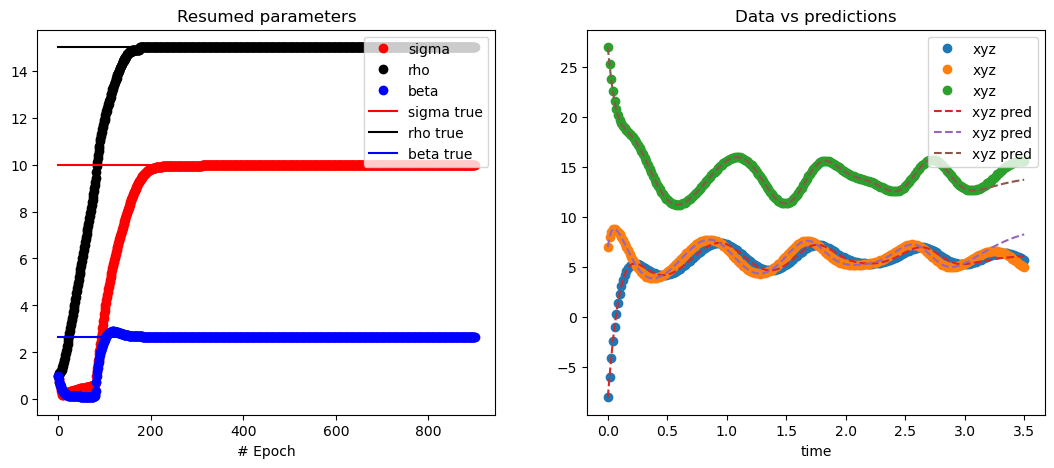

In [10]:
# reopen saved data using callbacks in fnamevar
lines = open( fnamevar , "r" ).readlines()
# read output data in fnamevar (this line is a long story...)
resumed_params = np.array( [ np.fromstring( min(re.findall(re.escape("[") + "(.*?)" + re.escape("]"), line), key=len), sep=",", ) for line in lines ] )

def plot2( resumed_params , lorenz ):
    
    fig = plt.figure( figsize = ( 13 , 5 ) )
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    
    l, c = resumed_params.shape
    ax1.plot( range(l) , resumed_params[:, 0] , "o" , color = "red" , label = "sigma" )
    ax1.plot( range(l) , resumed_params[:, 1] , "o" , color = "black" , label = "rho" )
    ax1.plot( range(l) , resumed_params[:, 2] , "o" , color = "blue" , label = "beta" )
    ax1.plot( range(l) , np.ones(resumed_params[:, 0].shape) * sigma_true , color = "red" , label = "sigma true" )
    ax1.plot( range(l) , np.ones(resumed_params[:, 1].shape) * rho_true , color = "black" , label = "rho true" )
    ax1.plot( range(l) , np.ones(resumed_params[:, 2].shape) * beta_true , color = "blue" , label = "beta true" )
    ax1.legend( loc = "upper right" )
    ax1.set_xlabel("# Epoch")
    ax1.set_title("Resumed parameters")
    
    # Define time domain.
    T = 3.5
    time = np.linspace( 0 , T , 250 )
    lorenz = odeint( RHSLorez , x0 , time )
    time = time.reshape(-1, 1)
    yhat = model.predict(time)
    ax2.plot( time , lorenz , "o" , label = "xyz")
    ax2.plot( time , yhat , "--" , label = "xyz pred")
    ax2.set_xlabel( "time" )
    ax2.legend( loc = "upper right")
    ax2.set_title( "Data vs predictions" )
    
    #plt.tight_layout()
    plt.show()

plot2( resumed_params , lorenz )